# Data Augmentation for Medical Datasets

> This script is for medical data augmentation. \
> All algorithms are final organized version.

## Packages

In [2]:
import os
import time
# import shap ## for XAI
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import pingouin as pg
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [3]:
from numpy import dot
from numpy.linalg import norm

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers import Dense , Activation, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import Callback

from scipy.special import rel_entr
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, ParameterGrid
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Concatenate, Dense, Lambda, Conv1D, Flatten, Reshape, UpSampling1D, MaxPooling1D, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import mse, MeanSquaredError, CategoricalCrossentropy 
from tensorflow.python.client import device_lib

In [4]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)
# scaler = RobustScaler()

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter

In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


***

## Dataset

> We will apply various types/domains medical dataset. \
> It includes public dataset and even own collected medical datasets.

###  dataset check

In [58]:
data_ori = pd.read_csv('E:/RESEARCH/Datasets/dissertation/heart_disease.csv') ## heart disease public dataset

In [59]:
print(f"The shape of the original dataset is: {data_ori.shape}")
data_ori.head()

The shape of the original dataset is: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [60]:
data_ori.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [61]:
data_B = data_ori[data_ori['target']==0]
data_M = data_ori[data_ori['target']==1]

In [62]:
sample_B = data_B.sample(n=260, random_state=710674)
sample_M = data_M.sample(n=526, random_state=710674)

# 두 샘플을 합쳐서 최종 데이터프레임 구성
data_sampled = pd.concat([sample_B, sample_M])

In [63]:
data_sampled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
878,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0
370,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0
349,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
600,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
429,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0


In [64]:
data_ori = data_sampled.copy()

In [65]:
data_ori['target'].value_counts()

target
1    526
0    260
Name: count, dtype: int64

In [66]:
data_ori.groupby('target')['sex'].value_counts()

target  sex
0       1      214
        0       46
1       1      300
        0      226
Name: count, dtype: int64

In [67]:
# 최소값과 최대값을 확인
min_age = data_ori['age'].min()
max_age = data_ori['age'].max()

# 연령 구간을 10살씩 끊어서 정의
age_bins = list(range(min_age // 10 * 10, max_age + 10, 10))  # 10살 간격으로 구간 정의
age_labels = [f"({i}, {i+10}]" for i in age_bins[:-1]]  # 구간 레이블 생성

# pd.cut()을 사용하여 연령을 구간별로 그룹화
data_ori['age_group'] = pd.cut(data_ori['age'], bins=age_bins, labels=age_labels, right=False)

# age_group을 카테고리형 변수로 변환하고 코드화 (0부터 시작)
data_ori['age_enc'] = pd.Categorical(data_ori['age_group']).codes

In [68]:
data_ori.age_group.value_counts()

age_group
(50, 60]    320
(40, 50]    198
(60, 70]    189
(30, 40]     48
(70, 80]     27
(20, 30]      4
Name: count, dtype: int64

In [69]:
data_ori.groupby('target')['age_group'].value_counts()

target  age_group
0       (50, 60]     114
        (60, 70]      88
        (40, 50]      41
        (30, 40]      10
        (70, 80]       7
        (20, 30]       0
1       (50, 60]     206
        (40, 50]     157
        (60, 70]     101
        (30, 40]      38
        (70, 80]      20
        (20, 30]       4
Name: count, dtype: int64

In [70]:
data_ori.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,age_enc
878,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0,"(50, 60]",3
370,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0,"(40, 50]",2
349,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0,"(60, 70]",4
600,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0,"(60, 70]",4
429,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0,"(40, 50]",2


### Unnecessary feature elimination

> Unnecessary features varies according to the analysis purpose. \
> Researcher should provide research goal or purpose of the augmentation model.

In [71]:
# drop_list = ['age_group']
# data_ori = data_ori.drop(drop_list, axis = 1 )

In [45]:
data_ori.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
878,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0
370,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0
349,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
600,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0
429,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0


### Visualization (hierarchical imbalance)

<Figure size 1000x700 with 0 Axes>

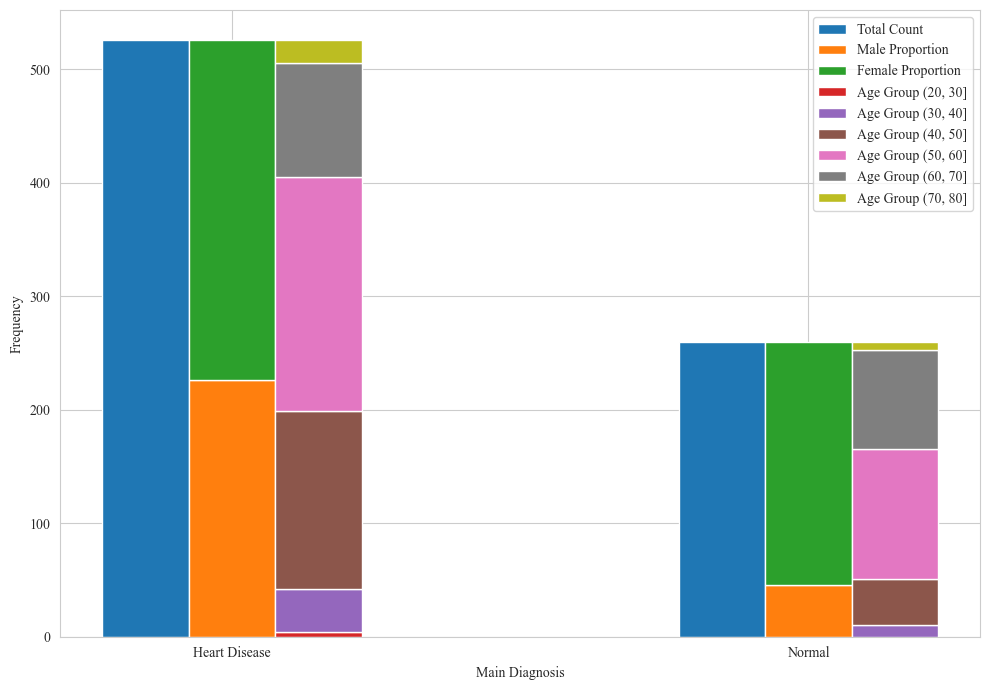

In [73]:
# main_dx별 개수 계산
main_dx_counts = data_ori['target'].value_counts()

# main_dx별 성별 비율 계산 (성별이 'M'과 'F'로 나누어짐)
gender_counts = data_ori.groupby(['target', 'sex']).size().unstack(fill_value=0)
gender_ratio = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# main_dx별 연령대 비율 계산 (연령대별 비율 계산)
age_counts = data_ori.groupby(['target', 'age_group']).size().unstack(fill_value=0)
age_ratio = age_counts.div(age_counts.sum(axis=1), axis=0)

# 그래프 크기 설정
plt.figure(figsize=(10, 7))
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

# x 위치 설정 (막대의 중심이 각 main_dx에 맞도록)
x = range(len(main_dx_counts))

# main_dx의 개수에 대한 막대 그리기
bar_width = 0.15
plt.bar(x, main_dx_counts.values, width=bar_width, label='Total Count', align='center')

# 성별 비율에 대한 막대 그리기 (남성 비율, 여성 비율)
male_height = gender_ratio.loc[main_dx_counts.index, 0] * main_dx_counts.values
female_height = gender_ratio.loc[main_dx_counts.index, 1] * main_dx_counts.values
plt.bar([i + bar_width for i in x], male_height, width=bar_width, label='Male Proportion', align='center')
plt.bar([i + bar_width for i in x], female_height, bottom=male_height, width=bar_width, label='Female Proportion', align='center')

# 연령대 비율에 대한 막대 그리기 (각 연령대에 대해 표시)
age_bar_width = 0.15  # 연령대 막대 너비 설정
bottoms = 0

# 연령대별 막대 그리기
for i, age_group in enumerate(age_ratio.columns):
    age_height = age_ratio.loc[main_dx_counts.index, age_group] * main_dx_counts.values
    plt.bar([i + bar_width*2 for i in x], age_height, width=age_bar_width, label=f'Age Group {age_group}', align='center', bottom=bottoms)
    # 누적된 bottom 값 업데이트
    bottoms += age_height

# x축, y축, 레이블 설정
plt.xlabel('Main Diagnosis')
plt.ylabel('Frequency')

# x축의 main_dx 이름을 세 개의 막대 중앙에 맞추기
plt.xticks([i + bar_width for i in x], main_dx_counts.index, rotation=0)
ax.set_xticklabels(['Heart Disease', 'Normal'])

# Legend 이름 변경
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()

### Hierarchical Imabalance Index (HII)

In [74]:
# data_ori는 이미 로드된 데이터프레임으로, target, gender, age_group 변수를 포함합니다

# 계층 목록
hierarchical_levels = ['target', 'sex', 'age_group']

# HII 계산 함수
def calculate_hii(data, levels):
    total_classes = sum(data[level].nunique() for level in levels)  # 전체 클래스 수
    hii = 0  # 최종 HII 값 초기화

    # 각 계층에 대해 불균형도(IR)를 계산하고 가중치를 적용합니다.
    for level in levels:
        # 해당 계층의 클래스 빈도 계산
        class_counts = data[level].value_counts()
        max_class_count = class_counts.max()  # 계층 내 최대 클래스 빈도
        num_classes = len(class_counts)  # 해당 계층의 클래스 수

        # 계층 불균형도(IR) 계산
        ir = sum(abs(count - max_class_count) for count in class_counts) / (num_classes * max_class_count)
        print(ir)

        # 계층 가중치 계산
        weight = num_classes / total_classes

        # HII에 가중치와 불균형도를 반영하여 더함
        hii += weight * ir

    return hii

# HII 계산
hii_value = calculate_hii(data_ori, hierarchical_levels)
print("Hierarchical Imbalance Index (HII):", hii_value)

0.25285171102661597
0.23540856031128404
0.590625
Hierarchical Imbalance Index (HII): 0.45202705426757994


***

***

# Data Augmentations

## dataset for model training

In [ ]:
data = data_ori.copy()

In [ ]:
data.shape

In [ ]:
data_vae = data.copy()
# data_vae = data_B.copy()
# data_vae = data_M.copy()

In [ ]:
data.age_group.value_counts()

***

## Conditional Variational Autoencoder (CVAE)

> Advantage of CVAE is adding label or more information to increase explainability.

In [ ]:
class Args_cvae:
    # arugments
    epochs=40
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    latent_dim = 2
    seed=710674

args_cvae = Args_cvae()

### preparing x, y dataset

> Applying scaler on dataset prevents "nan loss" issue during VAE training

In [ ]:
data_cvae = data.copy()
data_cvae.columns

In [ ]:
data_cvae['age_group_enc'] = pd.Categorical(data_cvae['age_group']).codes

In [ ]:
data_cvae = data_cvae.drop(['age', 'age_group'], axis=1)

In [ ]:
x = data_cvae.drop(['target', 'age_group_enc', 'sex'], axis=1)
x = x.fillna(x.mean()) ## filling na values with mean values (just drop the rows is also a possible option)
y = data_cvae.target
# c = data_cvae.loc[:,['age_group', 'sex']]

In [ ]:
condition1 = data_cvae['sex'].values  # First condition: sex
condition2 =data_cvae['age_group_enc'].values  # Second condition: age_group
condition3 = data_cvae['target'].values
c = np.stack([condition1, condition2, condition3], axis=1)

In [ ]:
data_cvae.age_group_enc.value_counts()

In [ ]:
# c

In [ ]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values
label = y.copy()
# label = label.replace({'B':0})
# label = label.replace({'M': 1})
data_y = to_categorical(label, 2) ## into the format of one-hot encoding
data_c = c.copy()

In [ ]:
label.value_counts()

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)
print("The size of c dataset is:", data_c.shape)

### CVAE model

In [ ]:
class CVAE:
    def __init__(self, input_dim, condition_dim, latent_dim):
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim

        # Encoder 및 Decoder 생성
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.cvae = self.build_cvae()
    
    def build_encoder(self):
        x_input = layers.Input(shape=(self.input_dim,), name='input')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')  # condition 입력 설정

        # x와 c를 결합하여 encoder 입력으로 사용
        combined_input = layers.Concatenate()([x_input, c_input])

        # Encoder 레이어 정의
        h = layers.Dense(64)(combined_input)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)

        h = layers.Dense(32)(h)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)

        z_mean = layers.Dense(self.latent_dim, name='z_mean')(h)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(h)

        # Sampling 레이어 (reparameterization trick)
        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        z = layers.Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        return Model([x_input, c_input], [z_mean, z_log_var, z], name='encoder')

    def build_decoder(self):
        z_input = layers.Input(shape=(self.latent_dim,), name='z_sampling')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')  # condition 입력 설정

        # z와 c를 결합하여 decoder 입력으로 사용
        combined_input = layers.Concatenate()([z_input, c_input])

        # Decoder 레이어 정의
        h = layers.Dense(32)(combined_input)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)

        h = layers.Dense(64)(h)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)

        x_decoded = layers.Dense(self.input_dim, activation='sigmoid', name='output')(h)

        return Model([z_input, c_input], x_decoded, name='decoder')

    def build_cvae(self):
        x_input = layers.Input(shape=(self.input_dim,), name='input')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')  # condition 입력 설정

        z_mean, z_log_var, z = self.encoder([x_input, c_input])
        x_decoded = self.decoder([z, c_input])

        cvae = Model([x_input, c_input], x_decoded, name='cvae')

        # Reconstruction과 KL Loss 정의
        reconstruction_loss = mse(x_input, x_decoded) * self.input_dim
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        cvae_loss = K.mean(reconstruction_loss + kl_loss)
        cvae.add_loss(cvae_loss)
        cvae.compile(optimizer='adam')

        return cvae

    # Model Training
    def train(self, x_train, c_train, epochs, batch_size, validation_split=None):
        self.cvae.fit([x_train, c_train], epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    
    # Synthetic Data Generation
    def generate_synthetic_data(self, condition, n_samples):
        z_samples = np.random.normal(size=(n_samples, self.latent_dim))
        synthetic_data = self.decoder.predict([z_samples, condition])
        return synthetic_data

    # Visualize Latent Space
    def visualize_latent_space(self, x_data, c_data, labels, n_samples):
        indices = np.random.choice(len(x_data), n_samples, replace=False)
        x_sample = x_data[indices]
        c_sample = c_data[indices]
        z_mean, _, _ = self.encoder.predict([x_sample, c_sample])
        
        tsne = TSNE(n_components=2, random_state=710674)
        z_tsne = tsne.fit_transform(z_mean)

        plt.figure(figsize=(8, 6))
        plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels[indices], cmap='viridis')
        plt.colorbar()
        plt.title('t-SNE Visualization of Latent Space')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()

In [ ]:
cvae = CVAE(input_dim = data_x.shape[1], condition_dim = data_c.shape[1], latent_dim=args_cvae.latent_dim)
cvae.train(data_x, data_c, epochs=args_cvae.epochs, batch_size=args_cvae.bs, validation_split=0.2)

### Latent space visualization

In [ ]:
x_data = np.array(data_x)
c_data = np.array(data_c)
labels = np.array(np.argmax(data_y, axis=1))

In [ ]:
cvae.visualize_latent_space(x_data, c_data, labels, n_samples=500)

### Synthetic data generation

* This section is to generate synthetic data using trained CVAE model

#### single CVAE model

In [ ]:
def generate_class_synthetic_data(cvae_model, c_data, n_samples_per_class, labels, method):
    synthetic_data = {}
    new_conditions = {}

    for class_label, n_samples in n_samples_per_class.items():
        ## filtering the condition for each class
        class_indices = np.where(labels == class_label)[0]
        class_conditions = c_data[class_indices]

        # 각 condition 변수에 대해 가능한 값들의 분포 계산
        condition_distributions = [Counter(class_conditions[:, i]) for i in range(class_conditions.shape[1])]
        
        ## generating new condition for conditional VAE data augmentation
        if method == 'adjusted_distribution':
            class_new_conditions = []
            for i, dist in enumerate(condition_distributions):
                # 각 변수의 고유값을 가져옴
                unique_vals = list(dist.keys())
                # 각 변수의 값에 대한 가중치를 계산 (빈도가 적은 값은 높은 가중치 부여)
                weights = [1 / dist[val] for val in unique_vals]
                weights = np.array(weights) / sum(weights)  # 가중치를 정규화

                # 부족한 값을 많이 샘플링
                new_samples = np.random.choice(unique_vals, n_samples, p=weights)
                class_new_conditions.append(new_samples)

            # 조건을 수집하여 새로운 조건 행렬 생성
            class_new_conditions = np.column_stack(class_new_conditions)

        # 원본 조건에 맞춰 new_conditions 생성
        new_conditions[class_label] = class_new_conditions

        # generate synthetic data using the new conditions
        class_synthetic_data = cvae_model.generate_synthetic_data(class_new_conditions, n_samples=n_samples)
        
        # save the synthesized results
        synthetic_data[class_label] = class_synthetic_data

    # return synthetic_data and new_conditions
    return synthetic_data, new_conditions

In [ ]:
# synthetic_data에 대해 scaler.transform을 적용하는 방법
def transform_synthetic_data_with_scaler(synthetic_data, scaler):
    transformed_data = {}

    for class_label, class_synthetic_data in synthetic_data.items():
        # NumPy 배열인 synthetic_data를 DataFrame으로 변환
        class_synthetic_df = pd.DataFrame(class_synthetic_data)

        # 원본 데이터의 스케일을 맞추기 위해 scaler.transform 적용
        class_synthetic_df_scaled = pd.DataFrame(scaler.transform(class_synthetic_df),
                                                 columns=class_synthetic_df.columns)

        transformed_data[class_label] = class_synthetic_df_scaled

    return transformed_data

In [ ]:
data_cvae.target.value_counts()

In [ ]:
n_samples_per_class = {0:526, 1:260} ## 1: disease, 0: normal

## synthetic data generation (augmentation)
synthetic_data, new_conditions = generate_class_synthetic_data(cvae, data_c, n_samples_per_class, label, method='adjusted_distribution')

# print("\n=====================================")
# print("Class 0 - Generated Synthetic Data: ")
# print(synthetic_data[0])
# print("\n=====================================")
# print("\nClass 1 - Generated Synthetic Data:")
# print(synthetic_data[1])

In [ ]:
# synthetic_data에 대해서 스케일러를 적용
transformed_synthetic_data = transform_synthetic_data_with_scaler(synthetic_data, scaler)

In [ ]:
transformed_synthetic_data

In [ ]:
# data_c

In [ ]:
# new_conditions

In [ ]:
def synthetic_dataframe(synthetic_data, data_x):
    dataframes = {}
    for class_label, data in synthetic_data.items():
        data_copy = data.copy()
        df = pd.DataFrame(data_copy, columns=data_x.columns)
        dataframes[class_label] = df
    return dataframes

In [ ]:
dataframes = synthetic_dataframe(synthetic_data, data_x)

# 클래스 0과 클래스 1에 대한 데이터프레임 추출
gen_N = dataframes[0]
gen_D = dataframes[1]

In [ ]:
gen_D.head()

***

# CVAE + attention (proposed)

* This approach adopts pytorch packages

In [140]:
data_cvat = data_ori.copy()

In [141]:
data_cvat.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,age_enc
878,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0,"(50, 60]",3
370,43,0,0,132,341,1,0,136,1,3.0,1,0,3,0,"(40, 50]",2
349,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0,"(60, 70]",4
600,62,0,2,130,263,0,1,97,0,1.2,1,1,3,0,"(60, 70]",4
429,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0,"(40, 50]",2


## Pytorch dataset definition

In [142]:
data_cvat.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_group',
       'age_enc'],
      dtype='object')

In [143]:
data_cvat = data_cvat.drop(['age', 'age_group'], axis=1)

In [144]:
# 2. 연령, 성별, 질병 변수를 condition으로 사용하기 위해 분리
x_data = data_cvat.drop(['sex', 'age_enc', 'target'], axis=1)
conditions = data_cvat[['age_enc', 'sex', 'target']]  # 연령, 성별, 질병 변수

# 3. 스케일링
scaler = StandardScaler()
x_data_scaled = scaler.fit_transform(x_data)

# 4. PyTorch Dataset 생성
class MedicalDataset(Dataset):
    def __init__(self, x_data, conditions):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.conditions = torch.tensor(conditions.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.conditions[idx]

dataset = MedicalDataset(x_data_scaled, conditions)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

## CVAETTENTION model

In [145]:
# CVAE 모델 정의
class CVAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim):
        super(CVAE, self).__init__()
        
        # 인코더
        self.latent_dim = latent_dim  # latent_dim 속성 추가
        self.encoder_fc1 = nn.Linear(input_dim + cond_dim, 128)
        self.encoder_fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        
        # 디코더
        self.decoder_fc1 = nn.Linear(latent_dim + cond_dim, 64)
        self.decoder_fc2 = nn.Linear(64, 128)
        
        # Attention Blocks
        self.self_attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        self.cross_attention = nn.MultiheadAttention(embed_dim=128, num_heads=4)
        
        # Reconstructing layer
        self.decoder_fc3 = nn.Linear(128, input_dim)
        
    def encode(self, x, cond):
        x = torch.cat([x, cond], dim=1)
        x = F.relu(self.encoder_fc1(x))
        x = F.relu(self.encoder_fc2(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        x = F.relu(self.decoder_fc1(x))
        x = F.relu(self.decoder_fc2(x))
        
        # Self-Attention: 생체신호-연령, 생체신호-성별 특징 반영
        x = x.unsqueeze(0)  # (1, batch, feature) 형식으로 변환
        x, _ = self.self_attention(x, x, x)
        
        # Cross-Attention: 연령, 성별이 생체신호에 주는 영향 반영
        x, _ = self.cross_attention(x, x, x)
        
        x = x.squeeze(0)
        x = self.decoder_fc3(x)
        return x

    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, cond)
        return recon_x, mu, logvar

In [146]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

model = CVAE(input_dim=11, cond_dim=3, latent_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, cond_batch in dataloader:
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x_batch, cond_batch)
        loss = loss_function(recon_x, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(dataloader.dataset)}")

Epoch 1, Loss: 10.869270091748419
Epoch 2, Loss: 9.962508611703344
Epoch 3, Loss: 9.792838972640098
Epoch 4, Loss: 9.677444030917025
Epoch 5, Loss: 9.67099061145734
Epoch 6, Loss: 9.562975817964277
Epoch 7, Loss: 9.564157617001133
Epoch 8, Loss: 9.45098777945715
Epoch 9, Loss: 9.415966315427202
Epoch 10, Loss: 9.432868627494832
Epoch 11, Loss: 9.316327781774312
Epoch 12, Loss: 9.243475469924112
Epoch 13, Loss: 9.282386352694369
Epoch 14, Loss: 9.175000333907343
Epoch 15, Loss: 9.020648985418655
Epoch 16, Loss: 8.92362826592443
Epoch 17, Loss: 8.753014989178295
Epoch 18, Loss: 8.697022746234147
Epoch 19, Loss: 8.72077837063156
Epoch 20, Loss: 8.7769888763816
Epoch 21, Loss: 8.637217902651876
Epoch 22, Loss: 8.660638804350798
Epoch 23, Loss: 8.55446290848516
Epoch 24, Loss: 8.53300474132897
Epoch 25, Loss: 8.608929466655237
Epoch 26, Loss: 8.405124382814986
Epoch 27, Loss: 8.55023874763314
Epoch 28, Loss: 8.403566472099634
Epoch 29, Loss: 8.464260305157145
Epoch 30, Loss: 8.2809522983075

In [148]:
# 조건에 따른 synthetic data 생성 함수
def generate_synthetic_data(model, sample_conditions_list):
    synthetic_samples = []

    for condition in sample_conditions_list:
        age, gender, disease = condition

        # 조건 텐서로 변환
        condition_tensor = torch.tensor([age, gender, disease], dtype=torch.float32).unsqueeze(0)

        # 잠재 공간에서 샘플링하여 synthetic data 생성
        with torch.no_grad():
            z = torch.randn(1, model.latent_dim)  # 모델의 latent_dim 크기에 맞게 샘플링
            synthetic_sample = model.decode(z, condition_tensor)  # 조건을 적용하여 디코더로 생성
            synthetic_samples.append(synthetic_sample.squeeze(0).numpy())  # numpy 배열로 변환

    synthetic_data = np.array(synthetic_samples)
    return synthetic_data

In [149]:
def sample_conditions(data, n):
    # 조건 변수 선택
    condition_data = data[['age_enc', 'sex', 'target']]
    
    # 목표 비율 계산 (target, sex, age_enc 각 클래스가 동일하게 분포된다고 가정)
    total_count = len(condition_data) + n
    unique_targets = condition_data['target'].unique()
    unique_sexes = condition_data['sex'].unique()
    unique_ages = condition_data['age_enc'].unique()
    
    target_goal_count = total_count / len(unique_targets)
    sex_goal_count = total_count / (len(unique_targets) * len(unique_sexes))
    age_goal_count = total_count / (len(unique_targets) * len(unique_sexes) * len(unique_ages))
    
    # 최종 샘플링 조건 리스트
    sampled_conditions = []
    
    for target in unique_targets:
        # target별로 필요한 샘플 수 계산
        current_target_count = condition_data[condition_data['target'] == target].shape[0]
        target_sample_count = max(0, int(target_goal_count - current_target_count))
        
        if target_sample_count > 0:
            for sex in unique_sexes:
                # sex별로 필요한 샘플 수 계산
                target_sex_data = condition_data[(condition_data['target'] == target) & (condition_data['sex'] == sex)]
                current_sex_count = target_sex_data.shape[0]
                sex_sample_count = max(0, int(sex_goal_count - current_sex_count))
                
                if sex_sample_count > 0:
                    for age in unique_ages:
                        # age_enc별로 필요한 샘플 수 계산
                        current_age_count = target_sex_data[target_sex_data['age_enc'] == age].shape[0]
                        age_sample_count = max(0, int(age_goal_count - current_age_count))
                        
                        # 필요한 샘플 수만큼 조건 추가
                        sampled_conditions.extend([[age, sex, target]] * age_sample_count)
                        
    # 최종 샘플링 조건 리스트 반환
    return sampled_conditions[:n]  # 요청된 n개만 반환


# 함수 실행 예시
sampled_conditions_list = sample_conditions(data_cvat, 260)
# print(sampled_conditions_list)

In [150]:
# 샘플링된 조건에 따른 synthetic data 생성
synthetic_data = generate_synthetic_data(model, sampled_conditions_list)
synthetic_data = scaler.inverse_transform(synthetic_data)  # 스케일링 역변환
# print("Synthetic Data Generated:\n", synthetic_data)

In [151]:
# 예시용 변수 이름 목록 (생체신호 변수 이름 11개)
signal_columns = ['cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang','oldpeak', 'slope', 'ca', 'thal']

def create_synthetic_dataframe(synthetic_data, sample_conditions_list):
    # 1. synthetic_data를 DataFrame으로 변환
    synthetic_df = pd.DataFrame(synthetic_data, columns=signal_columns)
    
    # 2. sample_conditions_list를 DataFrame으로 변환
    conditions_df = pd.DataFrame(sample_conditions_list, columns=['age_enc', 'sex', 'target'])
    
    # 3. synthetic_df와 conditions_df를 열 방향으로 결합
    combined_df = pd.concat([conditions_df, synthetic_df], axis=1)
    
    return combined_df

In [152]:
synthetic_df = create_synthetic_dataframe(synthetic_data, sampled_conditions_list)

print("Final Synthetic DataFrame Shape:", synthetic_df.shape)
# print("Synthetic DataFrame:\n", synthetic_df)

Final Synthetic DataFrame Shape: (260, 14)


In [153]:
# 예시: synthetic_df와 data의 컬럼 순서를 맞추기
data_cvat = data_cvat[synthetic_df.columns]

In [154]:
# synthetic_df와 data를 결합
combined_df = pd.concat([data_cvat, synthetic_df], ignore_index=True)

# 결과 확인
print("Combined DataFrame shape:", combined_df.shape)

Combined DataFrame shape: (1046, 14)


In [157]:
combined_df.groupby('target')['sex'].value_counts()

target  sex
0       1      330
        0      190
1       1      300
        0      226
Name: count, dtype: int64

***

***

## Comparative Methods

* To compare the data augmentation performance, we need to first implement other effective augmentation methods then use same approach for evaluation.

### Oversampling, undersampling, KMSMOTE

In [124]:
data_imp = data_ori.copy()
# data_imp = data_sampled.copy()

In [125]:
data_imp.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_group',
       'age_enc'],
      dtype='object')

In [126]:
data_imp = data_imp.drop(['age_group', 'age', 'sex'], axis=1)
# data_imp = data_imp.drop(['age', 'sex'], axis=1)

In [127]:
# data_imp.head()
data_imp.shape

(786, 13)

In [128]:
# X (특징)와 y (타겟)를 데이터에서 분리했다고 가정
x = data_imp.drop(['target'], axis=1)  # 특징
# x = x.fillna(x.mean())
y = data_imp['target']  # 타겟 변수

In [129]:
## 1. Undersampling (다수 클래스 샘플 줄이기)
undersampler = RandomUnderSampler(sampling_strategy='auto')
x_resampled_under, y_resampled_under = undersampler.fit_resample(x, y)
print("Undersampling 후 분포:", Counter(y_resampled_under))

## 2. Oversampling (소수 클래스 샘플 늘리기)
oversampler = RandomOverSampler(sampling_strategy='auto')
x_resampled_over, y_resampled_over = oversampler.fit_resample(x, y)
print("Oversampling 후 분포:", Counter(y_resampled_over))

## 3. KMeansSMOTE (KMeans 기반으로 소수 클래스 샘플 합성)
kmeans_smote = KMeansSMOTE(sampling_strategy='auto', random_state=710674)
x_resampled_kmsmote, y_resampled_kmsmote = kmeans_smote.fit_resample(x, y)
print("KMeansSMOTE 후 분포:", Counter(y_resampled_kmsmote))

## 각 결과를 다시 하나의 데이터프레임으로 변환
## Undersampling, Oversampling, KMSMOTE 결과들을 각각 데이터프레임으로 변환
df_resampled_under = pd.DataFrame(x_resampled_under, columns=x.columns)
df_resampled_under['target'] = y_resampled_under

df_resampled_over = pd.DataFrame(x_resampled_over, columns=x.columns)
df_resampled_over['target'] = y_resampled_over

df_resampled_kmsmote = pd.DataFrame(x_resampled_kmsmote, columns=x.columns)
df_resampled_kmsmote['target'] = y_resampled_kmsmote

Undersampling 후 분포: Counter({0: 260, 1: 260})
Oversampling 후 분포: Counter({0: 526, 1: 526})
KMeansSMOTE 후 분포: Counter({0: 527, 1: 526})


C:\Users\user\anaconda3\envs\paper\lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  # init_size
C:\Users\user\anaconda3\envs\paper\lib\site-packages\sklearn\cluster\_kmeans.py:1966: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  f"batch_size >= {self._n_threads * CHUNK_SIZE} or by "


***

***

# Classification performance check

## Original dataset only

In [75]:
data_dnn = data_ori.copy()
# data_dnn = df_resampled_under.copy()
# data_dnn = df_resampled_over.copy()
# data_dnn = df_resampled_kmsmote.copy()

In [76]:
data_dnn.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target', 'age_group',
       'age_enc'],
      dtype='object')

In [81]:
drop_list = ['target', 'age_group', 'age', 'sex', 'age_enc']
# drop_list = ['target', 'age_group']
# drop_list = ['target']

In [82]:
x = data_dnn.drop(drop_list, axis=1)
x = x.fillna(x.mean()) ## filling na values with mean values (just drop the rows is also a possible option)
y = data_dnn.target

In [83]:
x.shape

(786, 11)

In [84]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values

label = y.copy()
# label = label.replace({'B':0})
# label = label.replace({'M': 1})
data_y = to_categorical(label, 2) ## into the format of one-hot encoding

In [85]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 710674, stratify=data_y)

In [86]:
## definition for computing class weight (to solve class imbalance issue)
def compute_class_weights(y):
    class_counts = np.bincount(y) ## calculating data point for each class
    total_samples = len(y) ## total data points
    ## computing each class weight
    class_weights = {i: total_samples / (len(class_counts) * class_count) 
                     for i, class_count in enumerate(class_counts)}
    
    return class_weights

In [87]:
class_weight = compute_class_weights(label)
print(class_weight)

{0: 1.5115384615384615, 1: 0.747148288973384}


## Augmented dataset add

In [ ]:
data_aug = data_cvae.copy()

In [ ]:
data_aug = data_aug.drop(['sex', 'age_group_enc', 'target'], axis=1)

In [ ]:
data_aug_scaled = scaler.fit_transform(data_aug)
data_aug_new = pd.DataFrame(data_aug_scaled, columns = data_aug.columns)

In [ ]:
data_aug_new['target'] = label.values

In [ ]:
data_aug_new.head()

#### train test split

In [ ]:
def prepare_data_for_training(original_data, synthetic_data, target_column='target', test_size=0.2):
    # 1. synthetic_data에 column 이름 붙이고 target 열 추가
    # 원본 데이터에서 column 이름과 target 추가
    synthetic_data_with_target = []
    for class_label, class_synthetic_data in synthetic_data.items():
        # original_data에서 해당 class의 데이터 column 이름을 추출
        columns = original_data.drop(target_column, axis=1).columns
        synthetic_df = pd.DataFrame(class_synthetic_data, columns=columns)
        
        # 'target' 열 추가 (class_label에 해당하는 target 값 추가)
        synthetic_df[target_column] = class_label
        
        synthetic_data_with_target.append(synthetic_df)
    
    # 모든 synthetic data 합치기
    synthetic_data_with_target = pd.concat(synthetic_data_with_target, axis=0)
    
    # 2. 원본 데이터와 합치기
    original_data_with_target = original_data.copy()
    combined_data = pd.concat([original_data_with_target, synthetic_data_with_target], axis=0, ignore_index=True)
    
    # 3. 원본 데이터의 일부와 synthetic data를 합쳐서 훈련 데이터 만들기
    # train_test_split을 사용하여 원본 데이터에서 일부를 test_data로 분리
    train_data, test_data = train_test_split(original_data_with_target, test_size=test_size, stratify=original_data_with_target[target_column])

    # 훈련 데이터는 train_data와 synthetic_data 합치기
    training_data = pd.concat([train_data, synthetic_data_with_target], axis=0, ignore_index=True)

    return training_data, test_data

# 예시 사용
# 'data_cvae'는 원본 데이터, 'synthetic_data'는 synthetic data로 가정
training_data, test_data = prepare_data_for_training(data_aug_new, synthetic_data, target_column='target', test_size=0.4)

# 결과 확인
print("Training data shape:", training_data.shape)
print("Test data shape:", test_data.shape)

In [ ]:
training_data

In [ ]:
data_dnn = training_data.copy()

In [ ]:
x = data_dnn.drop('target', axis=1)
x = x.fillna(x.mean())
y = data_dnn.target

In [ ]:
data_x = x.copy()
label=y.copy()
data_y = to_categorical(label, 2)

## Simple DNN model

> To compare classification performance, we design simple structure of DNN.

In [88]:
class Args_dnn:
    # arugments
    epochs=50
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    seed=710674
    split=5

args_dnn = Args_dnn()

### DNN model

In [ ]:
class SimpleDNN:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim ## input data dimensionality (# variables)
        self.layer_configs = layer_configs ## hidden layer/sequential layer lists (units, activation, batch_norm, dropout_rate)
        self.output_units = output_units ## output unit no.
        self.output_activation = output_activation ## activation function for output layer
        self.model = self.build_model()
        self.callbacks = []

    def build_model(self):
        model = models.Sequential()
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], activation=self.layer_configs[0]['activation'], input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        
        return model

    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None, class_weight=None):
        if lr_scheduler:
            ## AddLearningRateScheduler callback
            self.callbacks.append(LearningRateScheduler(lr_scheduler))
        
        self.model.compile(optimizer, loss, metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_split=None, class_weight=None, validation_data=None):
        return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                             class_weight=class_weight, validation_data = validation_data, callbacks=self.callbacks)

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)

    def summary(self):
        self.model.summary()

In [93]:
def dynamic_learning_rate(epoch, mode='cyclic', base_lr=0.001, max_lr=0.006, step_size=25, gamma=0.99994):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    
    if mode == 'cyclic' or mode == 'triangular':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    elif mode == 'triangular2':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) / (2 ** (cycle - 1))
    elif mode == 'exp_range':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) * (gamma ** epoch)
    else:
        raise ValueError("Invalid mode. Choose from 'cyclic', 'triangular', 'triangular2', or 'exp_range'.")
    
    return lr

In [ ]:
# lr = dynamic_learning_rate(epoch=1000, mode='cyclic')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular2')
# lr = dynamic_learning_rate(epoch=1000, mode='exp_range', gamma=0.99994)

In [ ]:
x_train.shape

In [ ]:
## model initialization with hidden layer list below
layer_configs = [
    {'units': 32, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 16, 'activation': 'relu', 'batch_norm': False, 'dropout_rate': 0.3},
    {'units': 8, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.2}
]

model = SimpleDNN(output_units=args_dnn.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)

In [ ]:
## compile our model
opt = keras.optimizers.legacy.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='cyclic', base_lr=0.001, max_lr=0.009, step_size=25)
model.compile_model(optimizer = opt, lr_scheduler=scheduler)

## model summary
model.summary()

In [ ]:
## model training on training dataset
history = model.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, validation_split=0.2)
# history = model.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, class_weight = class_weight, validation_split=0.2)

### Evaluation

In [ ]:
def evaluate_model_performance(model, x_test, y_test):

    ## predict on model
    y_predict = model.predict(x_test)
    y_predict_classes = np.argmax(y_predict, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    ## calculate confusion matrix and visualize
    cm = confusion_matrix(y_test_classes, y_predict_classes, normalize='pred')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='.2f')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    ## evaluation metrics
    accuracy = metrics.accuracy_score(y_test_classes, y_predict_classes)
    precision = metrics.precision_score(y_test_classes, y_predict_classes, average='macro')
    recall = metrics.recall_score(y_test_classes, y_predict_classes, average='micro')
    f1 = metrics.f1_score(y_test_classes, y_predict_classes, average='weighted')
    auc = roc_auc_score(y_test, y_predict, multi_class='ovr')
    
    ## Results
    print("=============================================")
    print(f"The overall accuracy is: {accuracy:.4f}")
    print(f"The precision score is: {precision:.4f}")
    print(f"The recall score is: {recall:.4f}")
    print(f"The F1 score is: {f1:.4f}")
    print(f"The AUC score is: {auc:.4f}")
    print("=============================================")
    
    ## Print out the classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_predict_classes))

In [ ]:
evaluate_model_performance(model, x_test, y_test)

***

## k-fold

In [105]:
class Args_kfold:
    # arugments
    epochs=50
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    split=5
    seed=710674

args_kfold = Args_kfold()

In [106]:
class kfoldMLP:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim
        self.layer_configs = layer_configs
        self.output_units = output_units
        self.output_activation = output_activation
        self.callbacks = []
        self.model = None
        
    def build_model(self):
        model = models.Sequential()
        
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], 
                               activation=self.layer_configs[0]['activation'], 
                               input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        self.model = model

    ## model compile
    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None):
        if lr_scheduler:
            self.callbacks.append(tf.keras.callbacks.LearningRateScheduler(lr_scheduler))

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_data=None, class_weight=None, verbose=0):
        return self.model.fit(
            x_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=validation_data, 
            callbacks=self.callbacks, 
            class_weight=class_weight,
            verbose=verbose
        )

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        y_pred = self.model.predict(x)
        return np.array(y_pred)

    def summary(self):
        self.model.summary()

    def cross_validate(self, x_data, y_data, n_splits, epochs, batch_size, optimizer=None, class_weight=None):
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        kf = KFold(n_splits=n_splits, shuffle=True) ##set fold split and shuffle
        fold_metrics = []

        for fold, (train_index, val_index) in enumerate(kf.split(x_data), 1):
            x_train, x_val = x_data[train_index], x_data[val_index]
            y_train, y_val = y_data[train_index], y_data[val_index]

            ## build new model
            self.build_model()
            self.compile_model(optimizer=optimizer)
            
            ## model training
            self.fit_model(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), class_weight=class_weight, verbose=0)
            
            ## evaluate the model
            y_val_pred = self.predict(x_val)
            if isinstance(y_val_pred, list):
                y_val_pred = np.array(y_val_pred)
            y_val_pred = np.argmax(y_val_pred, axis=1)
            y_val_true = np.argmax(y_val, axis=1)
            
            accuracy = accuracy_score(y_val_true, y_val_pred)
            precision = precision_score(y_val_true, y_val_pred, average='macro')
            recall = recall_score(y_val_true, y_val_pred, average='macro')
            f1 = f1_score(y_val_true, y_val_pred, average='weighted')
            auc = roc_auc_score(y_val, self.predict(x_val), multi_class='ovr')
            
            fold_metrics.append({
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc': auc
            })

            print(f"Fold metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, AUC={auc:.4f}")
        
        avg_metrics = {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0].keys()}
        
        print("\nAverage metrics across all folds:")
        for metric, value in avg_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")

        return fold_metrics, avg_metrics

    # ## evaluation on test dataset (for performance check)
    # def evaluate_test_data(self, x_test, y_test):
    #     y_pred = self.predict(x_test)
    #     y_pred_labels = np.argmax(y_pred, axis=1)
    #     y_true_labels = np.argmax(y_test, axis=1)

    #     # Confusion Matrix
    #     cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='pred')
    #     plt.figure(figsize=(6, 4))
    #     sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    #     plt.title('Confusion Matrix')
    #     plt.ylabel('True Label')
    #     plt.xlabel('Predicted Label')
    #     plt.show()
    #     print("=============================================")
        
    #     ## evaluation metrics
    #     accuracy = accuracy_score(y_true_labels, y_pred_labels)
    #     precision = precision_score(y_true_labels, y_pred_labels, average='macro')
    #     recall = recall_score(y_true_labels, y_pred_labels, average='micro')
    #     f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
    #     auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
        
    #     ## Results
    #     print(f"The overall accuracy is: {accuracy:.4f}")
    #     print(f"The precision score is: {precision:.4f}")
    #     print(f"The recall score is: {recall:.4f}")
    #     print(f"The F1 score is: {f1:.4f}")
    #     print(f"The AUC score is: {auc:.4f}")
    #     print("=============================================")        

    #     # Classification Report
    #     class_report = classification_report(y_true_labels, y_pred_labels, target_names=[f'Class {i}' for i in range(self.output_units)])
    #     print("Classification Report:\n", class_report)

    #     return cm, class_report

In [107]:
## model initialization with hidden layer list below
## model initialization with hidden layer list below
layer_configs = [
    {'units': 16, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 8, 'activation': 'relu', 'batch_norm': False, 'dropout_rate': 0.3},
    {'units': 4, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.2}
]

# kfold = kfoldMLP(output_units=args_kfold.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)
kfold = kfoldMLP(output_units=args_kfold.num_classes, input_dim=data_x.shape[1], layer_configs=layer_configs)

In [108]:
## compile our model
opt = keras.optimizers.legacy.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='cyclic', base_lr=0.001, max_lr=0.009, step_size=25)

In [109]:
# K-Fold 교차 검증 실행
# metrics, avg_metrics = kfold.cross_validate(x_train, y_train, n_splits=args_kfold.split, optimizer=opt, epochs=args_kfold.epochs, batch_size=args_kfold.bs)
metrics, avg_metrics = kfold.cross_validate(data_x, data_y, n_splits=args_kfold.split, optimizer=opt, epochs=args_kfold.epochs, batch_size=args_kfold.bs)

# 각 폴드의 성능 지표 출력
for i, metric in enumerate(metrics):
    print(f"Fold {i+1}: {metric}")

5/5 [==============================] - 0s 748us/step
Fold metrics: Accuracy=0.7405, Precision=0.7373, Recall=0.5964, F1 Score=0.6895, AUC=0.8129
5/5 [==============================] - 0s 1ms/step
Fold metrics: Accuracy=0.8153, Precision=0.8386, Recall=0.7491, F1 Score=0.8015, AUC=0.8580
5/5 [==============================] - 0s 1ms/step
Fold metrics: Accuracy=0.7898, Precision=0.8099, Recall=0.7209, F1 Score=0.7727, AUC=0.8601
5/5 [==============================] - 0s 748us/step
Fold metrics: Accuracy=0.8217, Precision=0.8426, Recall=0.7544, F1 Score=0.8087, AUC=0.8917
5/5 [==============================] - 0s 919us/step
Fold metrics: Accuracy=0.7834, Precision=0.7566, Recall=0.7825, F1 Score=0.7886, AUC=0.8594

Average metrics across all folds:
Accuracy: 0.7901
Precision: 0.7970
Recall: 0.7207
F1_score: 0.7722
Auc: 0.8564
Fold 1: {'accuracy': 0.740506329113924, 'precision': 0.7372960372960373, 'recall': 0.5964015151515152, 'f1_score': 0.6894672012998925, 'auc': 0.8128787878787878}
Fol

* Evaluation on test dataset

In [ ]:
# cm, class_report = kfold.evaluate_test_data(x_test, y_test)

# Code Practice